<a href="https://www.kaggle.com/code/averma111/store-sales-tensorflow?scriptVersionId=125866823" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
ROOT_PATH = '/kaggle/input/store-sales-time-series-forecasting'
stores = pd.read_csv(ROOT_PATH+'/stores.csv')
train = pd.read_csv(ROOT_PATH+'/train.csv')
transactions = pd.read_csv(ROOT_PATH+'/transactions.csv')

In [3]:
## https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024 ** 2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [5]:
train = reduce_memory_usage(train)

Memory usage of dataframe is 40.14 MB
Memory usage became:  40.14344787597656  MB


In [6]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [7]:
summary('stores',stores)

stores shape: (54, 5)


,dtypes,null,unique,min,median,max,mean,std
store_nbr,int64,0,54,1,27.5,54,27.500000,15.732133
city,object,0,22,Ambato,NaN,Santo Domingo,NaN,NaN
state,object,0,16,Azuay,NaN,Tungurahua,NaN,NaN
type,object,0,5,A,NaN,E,NaN,NaN
cluster,int64,0,17,1,8.5,17,8.481481,4.693395


In [ ]:
summary('train',train)

In [8]:
summary('transactions',transactions)

transactions shape: (83488, 3)


,dtypes,null,unique,min,median,max,mean,std
date,object,0,1682,2013-01-01,NaN,2017-08-15,NaN,NaN
store_nbr,int64,0,54,1,27.0,54,26.939237,15.608204
transactions,int64,0,4993,5,1393.0,8359,1694.602158,963.286644


In [9]:
train = pd.merge(train,stores,how='left',on='store_nbr')
train.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [12]:
oil = pd.read_csv(ROOT_PATH+'/oil.csv')
oil['date'] = pd.to_datetime(oil['date'])

In [13]:
dates = pd.DataFrame(train.date.unique(),columns=['date'])
dates['date'] = pd.to_datetime(dates['date'])
oil = pd.merge(dates, oil, how="left", on="date")
oil = oil.set_index('date')
oil.shape

(1684, 1)

In [15]:
print(oil.query('dcoilwtico != dcoilwtico'))
print(oil.isnull().sum())

            dcoilwtico
date                  
2013-01-01         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-12         NaN
2013-01-13         NaN
...                ...
2017-07-30         NaN
2017-08-05         NaN
2017-08-06         NaN
2017-08-12         NaN
2017-08-13         NaN

[521 rows x 1 columns]
dcoilwtico    521
dtype: int64


In [22]:
fig = px.scatter(oil, x = oil.index, y ='dcoilwtico', title='Oil price change over the year')
fig.update_xaxes(
    rangeslider_visible = False,
)
fig.show()

In [23]:
oil_na = oil.copy()
oil_na.dropna()

,dcoilwtico
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21
...,...
2017-08-09,49.59
2017-08-10,48.54
2017-08-11,48.81


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

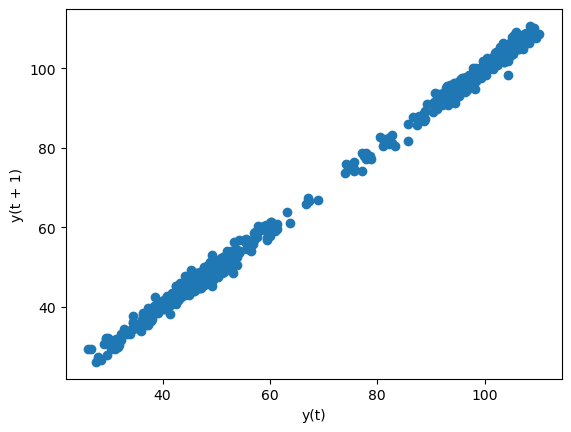

In [24]:
pd.plotting.lag_plot(oil['dcoilwtico'], lag= 1)

In [25]:
train['date'] = pd.to_datetime(train['date'])
train = train.set_index('date')

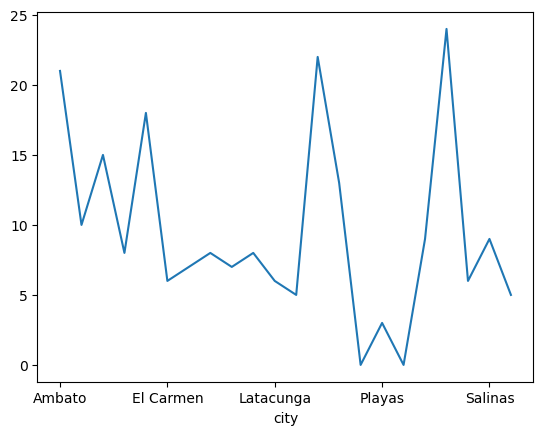

In [29]:
train.groupby(['city']).sales.median().plot(kind='line');

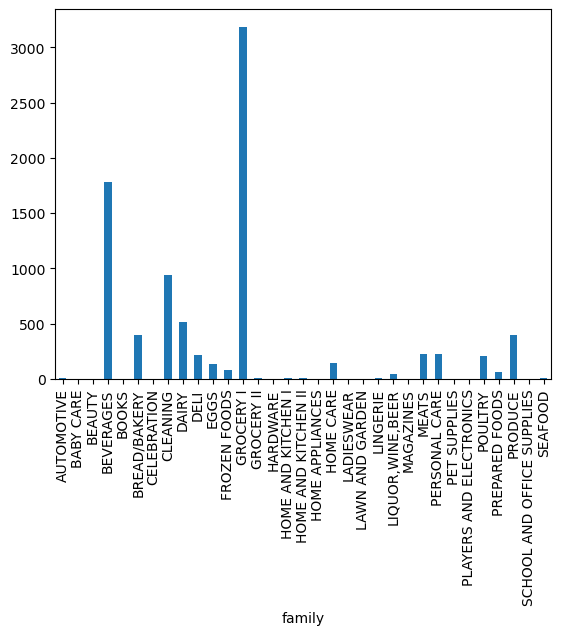

In [31]:
train.groupby(['family']).sales.median().plot(kind='bar');

In [38]:
train = pd.merge(train,oil,how='left',on='date')

ValueError: You are trying to merge on category and datetime64[ns] columns. If you wish to proceed you should use pd.concat